In [8]:
using CSV, DataFrames, Statistics
using Plots, StatsPlots
using ColorSchemes, Measures

function se(x)
    std(x)/sqrt(length(x))
end

se (generic function with 1 method)

In [2]:
prefix = "aistats-rev/"

"aistats-rev/"

# MEAN IMPUTATION

In [27]:
df = similar(CSV.read(prefix*"synthetic/"*"linear_mar/"*"FINAL_results.csv", DataFrame),0)
for dir = ["linear_mar/", "linear_censoring/", "nn_mar/", "nn_censoring/"]
# for dir = ["linear_mar/", "linear_censoring/", "nn_mar/", "nn_censoring/", "tree_mar/", "tree_censoring/"]
    directory = prefix*"synthetic/"*dir
    df = vcat(df, CSV.read(directory*"FINAL_results.csv", DataFrame)[:,names(df)])
    # df = vcat(df, CSV.read(directory*"HIGHN_results.csv", DataFrame)[:,names(df)])
end

#### Formatting Fixing

In [28]:
df[!,:n] .= map(t -> parse(Int,split(t,"_")[2]), df[:,:dataset]) ;
df[isnan.(df[:,:r2]),:r2] .= 0.
df[isnan.(df[:,:osr2]),:osr2] .= 0. ;

filter!(t -> t[:pMissing] <= 0.8, df)
filter!(t -> t[:n] > 20, df)

# df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 4" => "Mean Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 2" => "mice Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Joint Imp-then-Reg" => "Joint Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Static" => "Adaptive LR - Affine intercept"), df[:,:method]) ;

df

Row,dataset,SNR,k,pMissing,splitnum,method,r2,osr2,r2list,osr2list,muvec,time,hp,score,method_cat,X_setting,Y_setting,n
,String15,Int64,Int64,Float64,Int64,String31,Float64,Float64,String,String,String,Float64,String,Float64,String31,String15,String15,Int64
1,n_1000_p_10,2,5,0.1,1,XGBoost,0.867763,0.665557,"Any[0.8670880147422774, 0.8741652959398137, 0.9079461560636061, 0.8301653996873348, 0.9357979292111781, 0.8074834330936, 0.8679696943229437, 0.882208722845547, 0.862601239817399, 0.7901688685115005, 0.9060421274045598, 0.34144479363700575, 0.22846090338152314, 0.9626097970063168, 0.5961386307149869, 0.8413697547852105, 0.9069043604653245, 0.6235000317865542, 0.958102587028391, 0.608105394100185, 0.7070161506530841, 0.7635508941027063, 0.8140969548850339, 0.9894081414338083, 0.7742166285730437, 0.805805505452694, 0.5385225219452628, 0.7033380650929189, 0.891553736875657, 0.8110705538226934, 0.7126647844183887, 0.05135941522725518, 0.7782647290497838, -0.44611022897910013, 0.6390217872750555, 0.8595023987943273, 0.7720950490093842, 0.7785703904529087, 0.8872086813267762, 0.7559930968527795, 0.7391809518187746, -Inf, 0.7578071699265996, 0.5731517800169293, 0.9311936225795421, 0.69554742778856, 0.6726991354306974, 0.9471835143466918, 0.8172422878863244, 0.8808108817940847, 0.8982960899761009, -3.097435487172808, 0.759737971760359, 0.9013207568307327, 0.9703131999550991, -Inf, 0.8366041724772559, -Inf, -4.207952540686617, 0.5987014667995144, -Inf, -Inf, -Inf, -Inf, -Inf, 0.8812771668941323, -Inf, -Inf, -Inf, 0.45622498523821897, -Inf, -Inf, -Inf, -Inf, 0.272040096534126, -Inf, -Inf, 0.052168891342215806, 0.8632013624478727, -Inf, -Inf, -3.572845490149887, -Inf, -Inf, -Inf, -Inf, 0.9454301001015206, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -11.37004596473381, -Inf, 0.8527231212974538]","Any[0.6901022632979699, 0.7582530110690645, 0.7578907468604466, 0.7302011207066357, 0.7153988234783741, 0.6901903546684793, 0.6265871698504313, 0.6754314034951756, 0.7383453211081885, 0.48709669993313465, 0.69631393645832, 0.6229592137678541, 0.2165279249300689, 0.664065066642009, 0.6256456148517517, 0.7135100936445387, 0.911911502011368, 0.5723580348675505, 0.6862811713744261, 0.8859761318175525, 0.6880656698339617, 0.8008884217336599, 0.8273805351318478, 0.770865184043202, 0.7738742403618328, 0.5615292616430259, 0.526827104130964, 0.7555855063553801, 0.7107923231513097, 0.3777249497422769, 0.14796670695172043, 0.7929211329061656, 0.8905931628457238, 0.6810278424232001, 0.6067443464591418, 0.8724405444144466, 0.8338286190858484, 0.6967972265736014, 0.49896795199759514, 0.6166211286816126, 0.8766449474037058, 0.8150215283644264, 0.6816726450301132, 0.5245547899733656, 0.5244221677441013, 0.41774369740547923, 0.7770853177159475, 0.5907298119233896, 0.6092639823624639, 0.7694888801605578, 0.7366319430693117, 0.8011410671715307, 0.6157525261981169, 0.5110068884073233, 0.8292340919719074, 0.6157832592524478, 0.6431444414185286, 0.9271985486344526, -0.11880672688829774, 0.4074621663939749, 0.8444486628257372, 0.6255334026546728, 0.9663987234602667, 0.9474509877289716, -0.7394780535869541, 0.7946105494891792, -0.9080956864283238, 0.9696755132897166, 0.9273130200131017, 0.9801614170746121, 0.9772505364289308, 0.9671675298988358, 0.7082887136063901, 0.9281260777510287, NaN, 0.979062258645375, -0.23443109146657637, -46.79711331206637, 0.8451274910809863, 0.8778165791475974, 0.8970912658134563, -254.47926236677716, 0.6830137832757717, 0.8915930057960226, 0.9714212059488746, 0.9617020265452374, NaN, -1.5464466733021887, -0.7108943496382747, 0.7211417822484346, 0.6464183779490773, 0.6102602927430191, 0.9921794789006966, 0.9941082682130212, NaN, -6.102687219294461, 0.6101770047635877]",Any[],203.478,"Dict{Symbol, Real}(:min_child_weight => 5, :gamma => 0.0, :n_estimators => 50, :max_depth => 5)",0.679394,XGBoost,syn_X_mar,syn_Y_linear,1000
2,n_1000_p_10,2,5,0.1,1,Oracle X,0.777155,0.772589,"Any[0.7624418968609468, 0.7765633288096581, 0.8137549561707175, 0.805

#### Rename methods and generate the ``best'' variants

In [29]:
#Rename methods
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 4" => "Mean Impute-then-Regress"), df[:,:method])
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 2" => "mice Impute-then-Regress"), df[:,:method])

# df[!,:method] .= map(t -> replace(t, "Joint Imp-then-Reg" => "Joint Impute-then-Regress"), df[:,:method])

# df[!,:method] .= map(t -> replace(t, "Affine" => "Adaptive LR - Affine"), df[:,:method]) ;
# df[!,:method] .= map(t -> replace(t, "Finite" => "Adaptive LR - Finite"), df[:,:method]) ;
# df[!,:method] .= map(t -> replace(t, "Static" => "Adaptive LR - Affine intercept only"), df[:,:method])

# for method in ["Adaptive LR"]
#     aux = filter(t -> startswith(t[:method], method), df)
#     # @show size(aux)
#     idcols = [:dataset, :X_setting, :Y_setting, :n, :SNR, :k, :pMissing, :splitnum]
#     gd = groupby(aux, idcols)

#     aux = similar(aux, 0)
#     for subdf in gd 
#         scoremax = argmax(subdf[:,:score])
#         push!(aux, subdf[scoremax,names(aux)])
#     end
#     aux[!,:method] .= method*" - best"

#     df = vcat(df, aux)
# end

564465-element Vector{String}:
 "XGBoost"
 "Oracle X"
 "Oracle XM"
 "Complete Features"
 "CART MIA"
 "RF MIA"
 "Imp-then-Reg 1 - xgboost"
 "mice Impute-then-Regress - xgboost"
 "Imp-then-Reg 3 - xgboost"
 "Mean Impute-then-Regress - xgboost"
 ⋮
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"
 "Joint Imp-then-Reg - best"

#### (Figure 2) Plot R2 vs n for mean/mice then LR/RF

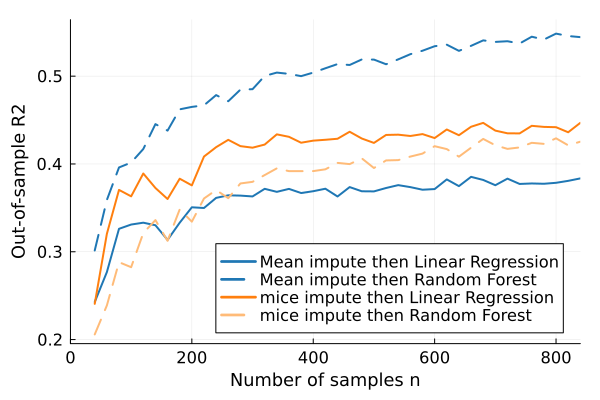

In [15]:
pal = ColorSchemes.tab20


y_setting = "syn_Y_nn" #Non-linear y
df_lin = filter(t-> t[:Y_setting] == y_setting, df)


gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
stats = combine(gd, :osr2 .=> [mean, se], nrow)
sort!(stats, [:n, :pMissing])

# setting = "syn_X_mar"
setting = "syn_X_censoring" #Missingness mechanism: Censoring

aux = filter(t -> t[:pMissing] == 0.4, stats) #Fraction of missingness entries: 0.4

@df filter(t -> t[:method] == "Mean Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
    margin = 3mm,
    label = "Mean impute then Linear Regression",
    color = pal[1], ls = :solid, lw = 2,
    legend=:bottomright, 
    guidefontsize=12, tickfontsize=11, legendfontsize=11,
    )

@df filter(t -> t[:method] == "Mean Impute-then-Regress - rf" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2, #yerr=:osr2_se, 
    label = "Mean impute then Random Forest",
    color = pal[1], ls = :dash, lw = 2)


@df filter(t -> t[:method] == "mice Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
    label = "mice impute then Linear Regression",
    color = pal[3], ls = :solid, lw = 2)


@df filter(t -> t[:method] == "mice Impute-then-Regress - rf" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
    label = "mice impute then Random Forest",
    color = pal[4], ls = :dash, lw = 2)

xaxis!("Number of samples n", xlims=(0,840))
yaxis!("Out-of-sample R2") #ylims=(0,0.92), yticks=collect(0.1:0.1:0.7))

In [12]:
mkpath("../figures/imputation_rules/mean_impute/")
savefig("../figures/imputation_rules/mean_impute/meanVSmice_nnY_censoringX_finitesample_parametric.pdf")

"/Users/jeanpauphilet/Dropbox/Work/1 - Research/PHD/figures/imputation_rules/mean_impute/meanVSmice_nnY_censoringX_finitesample_parametric.pdf"

#### (Figure 3 + Appendix) Plot R2 vs n for XGBoost (and RF)

In [14]:
pal = ColorSchemes.tab20

y_setting = "syn_Y_nn"
df_lin = filter(t-> t[:Y_setting] == y_setting, df)


gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
stats = combine(gd, :osr2 .=> [mean, se], nrow)
sort!(stats, [:n, :pMissing])

for setting = ["syn_X_mar", "syn_X_censoring"]
    aux = filter(t -> t[:pMissing] == 0.4, stats)

    @df filter(t -> t[:method] == "Mean Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
        margin = 3mm,
        label = "Mean impute then XGBoost",
        color = pal[1], ls = :solid, lw = 2,
        legend=:bottomright, 
        guidefontsize=11, tickfontsize=10, legendfontsize=11,
        )

    @df filter(t -> t[:method] == "mice Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot!(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
        label = "mice impute then XGBoost",
        color = pal[3], ls = :dash, lw = 2)

    @df filter(t -> t[:method] == "XGBoost" && t[:X_setting] == setting, aux) plot!(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
        label = "XGBoost",
        color = pal[5], ls = :dashdot, lw = 2)

    xaxis!("Number of samples n", xlims=(0,840))
    yaxis!("Out-of-sample R2") #ylims=(0,0.92), yticks=collect(0.1:0.1:0.7))

    savefig(string("../figures/imputation_rules/mean_impute/XGB_nnY_", setting == "syn_X_mar" ? "marX" : "censoringX", "_finitesample_parametric.pdf"))
end

for setting = ["syn_X_mar", "syn_X_censoring"]
    # setting = "syn_X_mar"
    aux = filter(t -> t[:pMissing] == 0.4, stats)

    @df filter(t -> t[:method] == "Mean Impute-then-Regress - rf" && t[:X_setting] == setting, aux) plot(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
        margin = 3mm,
        label = "Mean impute then Random Forest",
        color = pal[1], ls = :solid, lw = 2,
        legend=:bottomright, 
        guidefontsize=11, tickfontsize=10, legendfontsize=11,
        )

    @df filter(t -> t[:method] == "mice Impute-then-Regress - rf" && t[:X_setting] == setting, aux) plot!(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.1, #yerr=:osr2_se, 
        label = "mice impute then Random Forest",
        color = pal[3], ls = :dash, lw = 2)

    @df filter(t -> t[:method] == "RF MIA" && t[:X_setting] == setting, aux) plot!(
        :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
        label = "Random Forest",
        color = pal[5], ls = :dashdot, lw = 2)

    xaxis!("Number of samples n", xlims=(0,840))
    yaxis!("Out-of-sample R2") #ylims=(0,0.92), yticks=collect(0.1:0.1:0.7))

    savefig(string("../figures/imputation_rules/mean_impute/RF_nnY_", setting == "syn_X_mar" ? "marX" : "censoringX", "_finitesample_parametric.pdf"))
end

### (Figure 1) R2 vs. p Missing

In [17]:
#Mean vs. mice as a function of proportion of missing values (Figure ??)
for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
    # y_setting = "syn_Y_linear"
    for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
        # x_setting = "syn_X_censoring"
        df_lin = filter(t-> t[:Y_setting] == y_setting, df)

        gd = groupby(df_lin, [:pMissing, :method, :X_setting])
        stats = combine(gd, :osr2 .=> [mean, se])
        sort!(stats, [:pMissing])

        aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Mean Impute-then-Regress - best", "mice Impute-then-Regress - best"], stats)

        aux[!,:method] .= map(t -> replace(t, " - best" => ""), aux[:,:method])

        @df aux plot(
            :pMissing, :osr2_mean, yerr=:osr2_se, 
            group = :method,
            palette = pal, ls = :auto, lw = 2,
            legend=:bottomleft,
            # legend = :none,
            guidefontsize=10, tickfontsize=10, legendfontsize=11,
            )
        xaxis!("Proportion of missing values", xlims=(0,0.9))
        yaxis!("Out-of-sample R2") 

        savefig("../figures/imputation_rules/mean_impute/meanVSmice_"*y_setting*"_"*x_setting*".pdf")
    end
end

### (Figure Appendix) Heatmap mice vs. mean Impute

In [31]:
using Measures
for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
    for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
        df_lin = filter(t-> t[:Y_setting] == y_setting, df)


        gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
        stats = combine(gd, :osr2 .=> [mean, se])
        sort!(stats, [:pMissing, :n])
        filter!(t -> t[:n] <= 1000, stats )
        filter!(t -> t[:pMissing] <= 0.8, stats )


        aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Mean Impute-then-Regress - best", "mice Impute-then-Regress - best"], stats)

        widedf = unstack(aux, [:n, :pMissing], :method, :osr2_mean)
        widedf[!,:delta_osr2] = widedf[:,"Mean Impute-then-Regress - best"] .- widedf[:,"mice Impute-then-Regress - best"]
        widedf

        nvalues = sort(unique(widedf[:,:n]))
        pvalues = sort(unique(widedf[:,:pMissing]))
        Z = zeros(length(nvalues), length(pvalues))
        for (i,n) in enumerate(nvalues)
            for (j,p) in enumerate(pvalues)
                Z[i,j] = mean(widedf[(widedf[:,:n] .== n) .& (widedf[:,:pMissing] .== p),:delta_osr2])
            end
        end

        max_val = maximum(abs.(Z))

        xticks_range = 1:5:length(nvalues)
        yticks_range = 1:1:length(pvalues)
        heatmap(Z, 
            yticks=(xticks_range, nvalues[xticks_range]), xticks=(yticks_range, pvalues[yticks_range]),  
            color=cgrad([:red, :white, :green]), clims=(-max_val, max_val), margin = 8mm)
        xaxis!("Proportion of missing values")
        yaxis!("Number of observations",guidefontsize=12, tickfontsize=12, legendfontsize=11)


        savefig("../figures/imputation_rules/mean_impute/meanVSmice_heatmap_"*y_setting*"_"*x_setting*".pdf")


    end
end

# MODE IMPUTATION

In [21]:
df = similar(CSV.read("aistats-rev/synthetic_discrete/"*"linear_mar/"*"FINAL_results.csv", DataFrame),0)

for dir = ["linear_mar/", "linear_censoring/", "nn_mar/", "nn_censoring/"]
    directory = "aistats-rev/synthetic_discrete/"*dir
    df = vcat(df, CSV.read(directory*"FINAL_results.csv", DataFrame)[:,names(df)])
end

#### Formatting Fixing
df[!,:n] .= map(t -> parse(Int,split(t,"_")[2]), df[:,:dataset]) ;
df[isnan.(df[:,:r2]),:r2] .= 0.
df[isnan.(df[:,:osr2]),:osr2] .= 0. ;

filter!(t -> t[:pMissing] <= 0.8, df)
filter!(t -> t[:n] > 20, df);

In [22]:
#### Rename methods 
filter!(t -> t[:n] <= 1000 && (startswith(t[:method], "Imp-then-Reg 4") || startswith(t[:method], "Imp-then-Reg 5")), df);

#Rename methods
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 4" => "Missing-as-a-category"), df[:,:method])
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 5" => "Mode Impute"), df[:,:method])


156700-element Vector{String}:
 "Missing-as-a-category - xgboost"
 "Mode Impute - xgboost"
 "Missing-as-a-category - xgboost"
 "Mode Impute - xgboost"
 "Missing-as-a-category - xgboost"
 "Mode Impute - xgboost"
 "Missing-as-a-category - xgboost"
 "Mode Impute - xgboost"
 "Missing-as-a-category - xgboost"
 "Mode Impute - xgboost"
 ⋮
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"
 "Mode Impute - best"

In [20]:
mkpath("../figures/imputation_rules/mode_impute/")

"../figures/imputation_rules/mode_impute"

### (Figure )

In [26]:
using Measures
for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
    for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
        df_lin = filter(t-> t[:Y_setting] == y_setting, df)


        gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
        stats = combine(gd, :osr2 .=> [mean, se])
        sort!(stats, [:pMissing, :n])
        filter!(t -> t[:n] <= 1000, stats )
        filter!(t -> t[:pMissing] <= 0.8, stats )


        aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Missing-as-a-category - best", "Mode Impute - best"], stats)

        widedf = unstack(aux, [:n, :pMissing], :method, :osr2_mean)
        widedf[!,:delta_osr2] = widedf[:,"Mode Impute - best"] .- widedf[:,"Missing-as-a-category - best"]
        widedf

        nvalues = sort(unique(widedf[:,:n]))
        pvalues = sort(unique(widedf[:,:pMissing]))
        Z = zeros(length(nvalues), length(pvalues))
        for (i,n) in enumerate(nvalues)
            for (j,p) in enumerate(pvalues)
                Z[i,j] = mean(widedf[(widedf[:,:n] .== n) .& (widedf[:,:pMissing] .== p),:delta_osr2])
            end
        end

        max_val = maximum(abs.(Z))

        xticks_range = 1:5:length(nvalues)
        yticks_range = 1:1:length(pvalues)
        heatmap(Z, 
            yticks=(xticks_range, nvalues[xticks_range]), xticks=(yticks_range, pvalues[yticks_range]),  
            color=cgrad([:red, :white, :green]), clims=(-max_val, max_val), margin = 8mm)
        xaxis!("Proportion of missing values")
        yaxis!("Number of observations",guidefontsize=12, tickfontsize=12, legendfontsize=11)


        savefig("../figures/imputation_rules/mode_impute/modeVScategory_heatmap_"*y_setting*"_"*x_setting*".pdf")


    end
end

In [23]:
# pal = ColorSchemes.tab20

# for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
#     for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
#         df_lin = filter(t-> t[:Y_setting] == y_setting, df)
        
        
#         gd = groupby(df_lin, [:pMissing, :method, :X_setting])
#         stats = combine(gd, :osr2 .=> [mean, se])
#         sort!(stats, [:pMissing])
#         filter!(t -> t[:pMissing] <= 0.8, stats )
        
        
#         aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Missing-as-a-category - best", "Mode Impute - best"], stats)
        
#         @df aux plot(
#             :pMissing, :osr2_mean, #yerr=:osr2_se, 
#             group = :method,
#             palette = pal, ls = :auto, lw = 1.7,
#             legend=:topright,
#             guidefontsize=12, tickfontsize=12, legendfontsize=11,
#             )
#         xaxis!("Proportion of missing values", xlims=(0,1))
#         yaxis!("Out-of-sample R2") 
        
#         savefig("../figures/imputation_rules/mode_impute/modeVSnacategory"*y_setting*"_"*x_setting*".pdf")
#     end
# end

### --- OLD REBUTTAL STUFF --- 

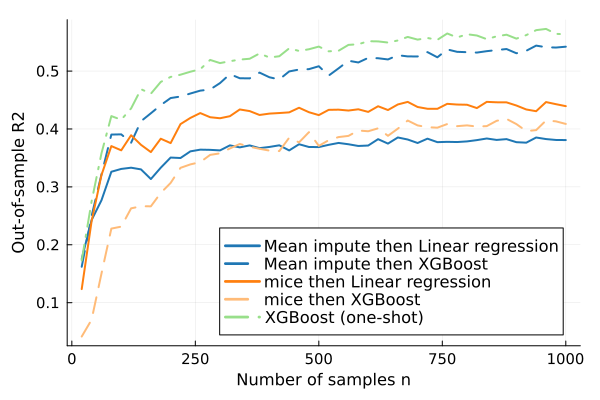

In [66]:
pal = ColorSchemes.tab20

# setting = "syn_X_mar"
setting = "syn_X_censoring"

aux = filter(t -> t[:pMissing] == 0.4, stats)

@df filter(t -> t[:method] == "Mean Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
    margin = 3mm,
    label = "Mean impute then Linear regression",
    color = pal[1], ls = :solid, lw = 2,
    legend=:bottomright, 
    guidefontsize=11, tickfontsize=10, legendfontsize=11,
    )

@df filter(t -> t[:method] == "Mean Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
    label = "Mean impute then XGBoost",
    color = pal[1], ls = :dash, lw = 2)


@df filter(t -> t[:method] == "mice Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
    label = "mice then Linear regression",
    color = pal[3], ls = :solid, lw = 2)


@df filter(t -> t[:method] == "mice Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
    label = "mice then XGBoost",
    color = pal[4], ls = :dash, lw = 2)

@df filter(t -> t[:method] == "XGBoost" && t[:X_setting] == setting, aux) plot!(
    :n, :osr2_mean, #ribbon=:osr2_se, fillalpha=0.2,
    label = "XGBoost (one-shot)",
    color = pal[6], ls = :dashdot, lw = 2)

xaxis!("Number of samples n")
yaxis!("Out-of-sample R2") #ylims=(0,0.92), yticks=collect(0.1:0.1:0.7))

savefig("../figures/mean_impute/rebuttal/"*"meanVSmice_linearY_censoringX_finitesample_parametric.pdf")

In [13]:
mkpath("../figures/mean_impute/rebuttal/")

"../figures/mean_impute/rebuttal"

In [25]:
for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
    # y_setting = "syn_Y_linear"
    for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
        # x_setting = "syn_X_censoring"
    # y_setting = "syn_Y_linear"
    df_lin = filter(t-> t[:Y_setting] == y_setting, df)
    
    
    gd = groupby(df_lin, [:pMissing, :method, :X_setting])
    stats = combine(gd, :osr2 .=> [mean, se])
    sort!(stats, [:pMissing])
    filter!(t -> t[:pMissing] <= 0.8, stats )
    
    
    aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Mean Impute-then-Regress - best", "mice Impute-then-Regress - xgboost", "XGBoost"], stats)
    
    aux[!,:method] .= map(t -> replace(t, " Impute-then-Regress - xgboost" => " then XGBoost"), aux[:,:method])
    
    @df aux plot(
        :pMissing, :osr2_mean, yerr=:osr2_se, 
        group = :method,
        palette = ColorSchemes.tab10, ls = :auto, lw = 2,
        legend=:bottomleft,
        # legend = :none,
        guidefontsize=10, tickfontsize=10, legendfontsize=11,
        )
    xaxis!("Proportion of missing values", xlims=(0,0.9))
    yaxis!("Out-of-sample R2") 
    
    savefig("../figures/mean_impute/rebuttal/"*"meanVSmiceVSxgb_"*y_setting*"_"*x_setting*"_as_of_pMissing.pdf")
    
    
    end
end

for y_setting = ["syn_Y_linear", "syn_Y_nn"]

    df_lin = filter(t-> t[:Y_setting] == y_setting, df)
    gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
    stats = combine(gd, :osr2 .=> [mean, se])
    sort!(stats, [:n, :pMissing])

    # setting = "syn_X_mar"
    for setting = ["syn_X_mar", "syn_X_censoring"]

        aux = filter(t -> t[:pMissing] == 0.4 && t[:X_setting] == setting, stats)
        # aux = stats
        # @df filter(t -> t[:method] == "Mean Impute-then-Regress - xgboost", aux) plot(
        #     :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.2,
        #     margin = 3mm,
        #     label = "Mean Impute then XGBoost",
        #     color = pal[9], ls = :dot, lw = 2,
        #     legend=:bottomright, 
        #     guidefontsize=11, tickfontsize=10, legendfontsize=11,
        #     )

        # @df filter(t -> t[:method] == "Mean Impute-then-Regress - linear", aux) plot!(
        #     :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.2,
        #     label = "Mean Impute then Linear",
        #     color = pal[1], ls = :solid, lw = 2
        # )

        # # @df filter(t -> t[:method] == "Mean Impute-then-Regress - best", aux) plot(
        # #     :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.3,
        # #     label = "Mean Impute-then-Regress",
        # #     color = pal[1], ls = :dash, lw = 2, 
        # #     margin = 3mm,
        # #     legend=:bottomright, 
        # #     guidefontsize=11, tickfontsize=10, legendfontsize=11,
        # # )

        # @df filter(t -> t[:method] == "XGBoost" && t[:X_setting] == setting, aux) plot!(
        #     :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.2,
        #     label = "XGBoost",
        #     color = pal[5], ls = :dashdot, lw = 2)

            @df filter(t -> t[:method] == "Mean Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot(
                :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.1,
                margin = 3mm,
                label = "Mean impute then Linear regression",
                color = pal[1], ls = :solid, lw = 2,
                legend=:bottomright, 
                guidefontsize=11, tickfontsize=10, legendfontsize=11,
                )

            @df filter(t -> t[:method] == "Mean Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot!(
                :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.2,
                label = "Mean impute then XGBoost",
                color = pal[1], ls = :dash, lw = 2)


            @df filter(t -> t[:method] == "mice Impute-then-Regress - linear" && t[:X_setting] == setting, aux) plot!(
                :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.1,
                label = "mice then Linear regression",
                color = pal[3], ls = :solid, lw = 2)


            @df filter(t -> t[:method] == "mice Impute-then-Regress - xgboost" && t[:X_setting] == setting, aux) plot!(
                :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.1,
                label = "mice then XGBoost",
                color = pal[4], ls = :dash, lw = 2)

            @df filter(t -> t[:method] == "XGBoost" && t[:X_setting] == setting, aux) plot!(
                :n, :osr2_mean, ribbon=:osr2_se, fillalpha=0.2,
                label = "XGBoost (one-shot)",
                color = pal[6], ls = :dashdot, lw = 2)

        xaxis!("Number of samples n", xlims=(0,840))
        yaxis!("Out-of-sample R2") #ylims=(0,0.92), yticks=collect(0.1:0.1:0.7))

        savefig("../figures/mean_impute/rebuttal/"*"meanVSmice_"*y_setting*"_"*setting*".pdf")
        savefig("../figures/mean_impute/rebuttal/"*"meanVSmice_"*y_setting*"_"*setting*".png")

    end
end

In [15]:
pal

In [27]:
#Heatmap (Appendix)
using Measures
for y_setting ∈ ["syn_Y_linear", "syn_Y_nn"] 
    # y_setting = "syn_Y_linear"
    for x_setting ∈ ["syn_X_mar", "syn_X_censoring"]
        # x_setting = "syn_X_censoring"

        df_lin = filter(t-> t[:Y_setting] == y_setting, df)


        gd = groupby(df_lin, [:pMissing, :n, :method, :X_setting])
        stats = combine(gd, :osr2 .=> [mean, se])
        sort!(stats, [:pMissing, :n])
        filter!(t -> t[:n] <= 1000, stats )
        filter!(t -> t[:pMissing] <= 0.8, stats )

        aux = filter(t -> t[:X_setting] == x_setting && t[:method] ∈ ["Mean Impute-then-Regress - best", "mice Impute-then-Regress - best"], stats)

        widedf = unstack(aux, [:n, :pMissing], :method, :osr2_mean)
        widedf[!,:delta_osr2] = widedf[:,"mice Impute-then-Regress - best"] .- widedf[:,"Mean Impute-then-Regress - best"]
        widedf

        nvalues = sort(unique(widedf[:,:n]))
        pvalues = sort(unique(widedf[:,:pMissing]))
        Z = zeros(length(nvalues), length(pvalues))
        for (i,n) in enumerate(nvalues)
            for (j,p) in enumerate(pvalues)
                Z[i,j] = mean(widedf[(widedf[:,:n] .== n) .& (widedf[:,:pMissing] .== p),:delta_osr2])
            end
        end

        max_val = maximum(abs.(Z[.!isnan.(Z)]))
        # @show max_val
        xticks_range = 1:5:length(nvalues)
        yticks_range = 1:1:length(pvalues)
        heatmap(Z, 
            yticks=(xticks_range, nvalues[xticks_range]), xticks=(yticks_range, pvalues[yticks_range]),  
            color=cgrad([:red, :white, :green]), 
            clims=(-max_val, max_val),
            margin = 8mm)
        xaxis!("Proportion of missing values")
        yaxis!("Number of observations",guidefontsize=12, tickfontsize=12, legendfontsize=11)


        savefig("../figures/mean_impute/meanVSmice_heatmap_"*y_setting*"_"*x_setting*".pdf")


    end
end